# Assessing Support and Overlap with OverRule

## Motivation

When performing backdoor adjustment, even if we correctly specify the causal graph and observe all the relevant variables $X$ for backdoor adjustment, we can only estimate causal effects for individuals with covariates $X$ that satisfy two conditions: 
* Support: Simply put, we require that we observe similar individuals in our dataset.  For discrete covariates $X$, this can be formalized as requiring that $$P(X) > 0$$
* Overlap: We require that there is some possibility of observing both the treatment and control for similar individuals.  Formally, we require that $$1 > P(T = 1 \mid X) > 0$$

OverRule [1] is a method for learning Boolean Rule Sets that characterize the set of individuals who satisfy both conditions, and is demonstrated in this notebook on some simple examples to build intuition.

## Acknowledgements

Code for OverRule is adapted (with minimal modifications, but some simplifications) from https://github.com/clinicalml/overlap-code, under the MIT License.

[1] Oberst, M., Johansson, F., Wei, D., Gao, T., Brat, G., Sontag, D., & Varshney, K. (2020). Characterization of
Overlap in Observational Studies. In S. Chiappa & R. Calandra (Eds.), Proceedings of the Twenty Third International
Conference on Artificial Intelligence and Statistics (Vol. 108, pp. 788–798). PMLR. https://arxiv.org/abs/1907.04138

# Table of contents <a name="toc"></a>
1. [Illustration on a simple 2D example](#2dexample)
    1. [Problem Data](#2d_problemdata)
    2. [Applying OverRule with default arguments](#2d_applyingOverRule)
    3. [Interpreting the output of OverRule](#2d_interpret_output)
    4. [Configuring OverRule](#2d_configuration)
2. [Illustration on Lalonde and PSID datasets](#lalonde")

In [1]:
import numpy as np
import pandas as pd

import dowhy.datasets
from dowhy import CausalModel
# Functional API
from dowhy.causal_refuters.assess_overlap import assess_support_and_overlap_overrule

# Data classes to configure ruleset optimization
from dowhy.causal_refuters.assess_overlap_overrule import SupportConfig, OverlapConfig

import matplotlib.pyplot as plt

# Illustration on a simple 2D example <a name="2dexample"></a>

[Back to Table of Contents](#toc)

## Problem Data <a name="2d_problemdata"></a>
[Back to Table of Contents](#toc)

In this example, we have a pair of binary covariates $X_1, X_2$, with simple violations of the above conditions:
* Support: There are no samples where $X_1 = X_2 = 1$, i.e., $P(X_1 = 1, X_2 = 1) = 0$ 
* Overlap: Only individuals with $X_1 = 0, X_2 = 0$ have a chance of recieving both treatment $(T = 1)$ and control $(T = 0)$

In [2]:
test_data = pd.DataFrame(
        np.array(
            [
                [0, 0, 1, 1],
                [0, 0, 0, 0],
                [0, 1, 1, 0],
                [1, 0, 0, 0],
            ]
            * 50
        ),
        columns=["X1", "X2", "T", "Y"],
    )

We can visualize these patterns as follows, where we **add some jitter** to the values to makes things easier to see

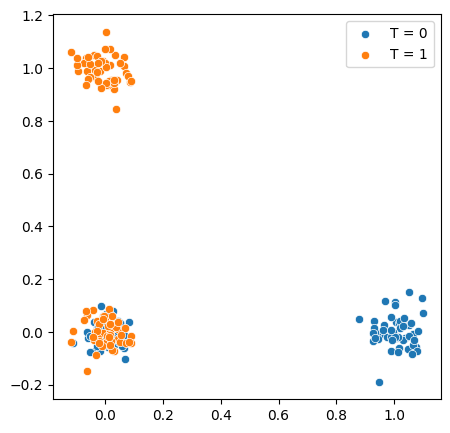

In [3]:
rng = np.random.default_rng(0)
jitter_data = test_data.copy()
jitter_data['X1'] = jitter_data['X1'] + rng.normal(0, 0.05, size=(200,)) 
jitter_data['X2'] = jitter_data['X2'] + rng.normal(0, 0.05, size=(200,)) 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for t in [0, 1]:
    this_data = jitter_data.query('T == @t')
    ax.scatter(this_data['X1'], this_data['X2'], label=f'T = {t}', edgecolor='w', linewidths=0.5)

plt.legend()
plt.show()

Notice how the only region where overlap holds is when $X_1 = X_2 = 0$.

## Applying OverRule with default arguments <a name="2d_applyingOverRule"></a>
[Back to Table of Contents](#toc)

This method is currently implemented as a refutation method, though it can also be accessed through the functional API.  We illustrate both methods below, before discussing their arguments.

Note that OverRule returns rules in Disjunctive Normal Form (DNF), which can be read as an OR of ANDs, and are given when `print(refute)` is called.

### Example usage using CausalModel

In [4]:
model = CausalModel(
    data=test_data,
    treatment="T",
    outcome="Y",
    common_causes=['X1', 'X2']
)

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

In [6]:
# We disucss configuration in more depth below.
support_config = SupportConfig(seed=0)
overlap_config = OverlapConfig()

In [7]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name='assess_overlap', 
    support_config=support_config, 
    overlap_config=overlap_config,
)

In [8]:
print(refute)

Rules cover 50.0% of all samples
Overall, 50.0% of samples meet the criteria for inclusion in the overlap set, 
defined as (a) being covered by support rules and having propensity
score in (0.10, 0.90)
Rules capture 100.0% of samples which meet these criteria

How to read rules: The following rules are given in Disjuntive Normal Form, 
a series of AND clauses (e.g., X and Y and Z) joined by ORs. Hence, if a sample 
 satifies any of the clauses for the support rules, it is included in the support, 
and likewise for the overlap rules.

DETAILED RULES:
SUPPORT Rules: Found 2 rule(s), covering 100.0% of samples
	    Rule #0: (not X1)
		 [Covers 75.0% of samples]
	 OR Rule #1: (X1)
		 AND (not X2)
		 [Covers 25.0% of samples]
OVERLAP Rules: Found 1 rule(s), covering 50.0% of samples
	    Rule #0: (not X1)
		 AND (not X2)
		 [Covers 50.0% of samples]



### Example usage using the Functional API



Note that the outcome $Y$ is not used as part of OverRule, so it is not required here.

In [9]:
refute = assess_support_and_overlap_overrule(
    data=test_data, 
    backdoor_vars=['X1', 'X2'], 
    treatment_name='T', 
    support_config=support_config, 
    overlap_config=overlap_config
)

### Only fitting support or overlap rules

You can also run OverRule to **only** learn either support or overlap rules, by passing in either `support_only=True` or `overlap_only=True`.

In [10]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name='assess_overlap', 
    support_only=True,
    support_config=support_config,
)

In [11]:
print(refute)

Rules cover 100.0% of all samples

How to read rules: The following rules are given in Disjuntive Normal Form, 
a series of AND clauses (e.g., X and Y and Z) joined by ORs. Hence, if a sample 
 satifies any of the clauses for the support rules, it is included in the support, 
and likewise for the overlap rules.

DETAILED RULES:
SUPPORT Rules: Found 2 rule(s), covering 100.0% of samples
	    Rule #0: (not X1)
		 [Covers 75.0% of samples]
	 OR Rule #1: (X1)
		 AND (not X2)
		 [Covers 25.0% of samples]
No Overlap Rules Fitted (support_only=True).


In [12]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='assess_overlap', 
    overlap_only=True, 
    overlap_config=overlap_config
)

In [13]:
print(refute)

Rules cover 50.0% of all samples
Overall, 50.0% of samples meet the criteria for inclusion in the overlap set, 
defined as (a) being covered by support rules and having propensity
score in (0.10, 0.90)
Rules capture 100.0% of samples which meet these criteria

How to read rules: The following rules are given in Disjuntive Normal Form, 
a series of AND clauses (e.g., X and Y and Z) joined by ORs. Hence, if a sample 
 satifies any of the clauses for the support rules, it is included in the support, 
and likewise for the overlap rules.

DETAILED RULES:
No Support Rules Fitted (overlap_only=True).
OVERLAP Rules: Found 1 rule(s), covering 50.0% of samples
	    Rule #0: (not X1)
		 AND (not X2)
		 [Covers 50.0% of samples]



## Interpreting the output of OverRule <a name="2d_interpret_output"></a>
[Back to Table of Contents](#toc)

We will use the following set of rules to illustrate how to interpret the output.

```
SUPPORT Rules: Found 2 rule(s), covering 100.0% of samples
	    Rule #0: (not X1)
             [Covers 75.0% of samples]
	 OR Rule #1: (X1)
             AND (not X2)
             [Covers 25.0% of samples]
OVERLAP Rules: Found 1 rule(s), covering 50.0% of samples
	    Rule #0: (not X2)
             AND (not X1)
             [Covers 50.0% of samples]
```

For any sample, we can check if the sample is covered by the support by checking each rule (Rule 0 and Rule 1).  The sample is in the support if ANY of these rules apply.  Consider a point (X1 = 1, X2 = 1), which we know is not in the support of our original data.  Since each binary input is treated as a boolean, we can check:
* Rule 0: (not X1) --> This rule is not satisfied by (X1 = 1, X2 = 1), because X1 = 1 is equivalent to X2 = True
* Rule 1: (X1) AND (not X2) --> This rule is not satisfied, because X2 = 1

Similarly, we can check if a sample is covered by the overlap rules.  Consider the point (X1 = 1, X2 = 0).  This satisfies the support rules because it matches Rule 0.  For the overlap rules, however, we can check:
* Rule 0: (not X2) AND (not X1) --> This rule is not satisfied, because X1 = 1.

**Note**: When we later filter samples based on the rules learned by OverRule, we will filter out any samples that do not match BOTH a support rule, and an overlap rule.

## Configuring OverRule <a name="2d_configuration"></a>
[Back to Table of Contents](#toc)

OverRule can be configured by passing in the following arguments
* `overlap_eps`: This should be a number $\epsilon$ in (0, 0.5) which defines the overlap region as those points where $P(T = 1 \mid X)$ is in $(\epsilon, 1 - \epsilon)$.

* `cat_feats`: A list of any categorical features (automatically inferred if dtype is object).

* `support_config`: A `SupportConfig` (see below), which controls optimization parameters

* `overlap_config`: An `OverlapConfig` (see below), which controls optimization parameters

In [14]:
support_config = SupportConfig()
print(support_config)

SupportConfig(n_ref_multiplier=1.0, seed=None, alpha=0.98, lambda0=0.01, lambda1=0.001, K=20, D=20, B=10, iterMax=10, num_thresh=9, thresh_override=None, solver='ECOS', rounding='greedy_sweep')


In [15]:
overlap_config = OverlapConfig()
print(overlap_config)

OverlapConfig(alpha=0.95, lambda0=0.001, lambda1=0.001, K=20, D=20, B=10, iterMax=10, num_thresh=9, thresh_override=None, solver='ECOS', rounding='greedy_sweep')


**Key Parameters**: For `SupportConfig` and `OverlapConfig`, the defaults are generally sensible, but some may be worth changing depending on the problem, and are detailed below.

* `alpha`: 
    + For learning support rules, we require that at least an `alpha` fraction of the original data is included, while minimizing the volume of the resulting support set.  
    + For learning overlap rules, at least an `alpha` fraction of the "overlap points" must be included, while excluding as many non-overlap points as possible.  Here, the "overlap points" are defined as those where $P(T = 1 \mid X)$ is within `[overlap_eps, 1 - overlap_eps]`, estimated using an XGBClassifier.
* `lambda0`, `lambda1`: These are regularization terms which control the complexity of the final rules. 
    + `lambda0` is a penalty added for every new rule (which can contain multiple literals).  For instance, `(not X1) AND (not X2)` is a single rule. 
    + `lambda1` is a penalty added for every literal.  For instance, `(not X1) AND (not X2)` contains two literals.
* `num_thresh`: OverRule turns all features into binary rules before learning rulesets.  For continuous variables, it does so (by default) by converting into deciles.  This default behavior can be changed via changing the number of thresholds, or specifying a dictionary (in `thresh_override`) that maps features to a `np.ndarray` of thresholds.

# Illustration on Lalonde and PSID datasets <a name="lalonde"></a>
[Back to Table of Contents](#toc)

In this section, we show how OverRule can be applied in the course of doing another causal analysis. Here, we demonstrate both
* Using OverRule prior to conducting analysis
* Filtering samples using the learned rules

Incorporating OverRule into a causal inference workflow looks like
* First, applying OverRule to learn rules, before any causal effect estimation is performed
* Second, filtering samples according to the learned rules
* Third, estimating causal effects on the filtered sample

For this illustration, we use two datasets to construct a somewhat artificial causal inference task:
* The original dataset from Lalonde (1986), which contains experimental samples, and which is loaded via `dowhy.datasets.lalonde_dataset()`.  Because this is an *experimental* sample, we will see that **overlap holds for all the samples in this sample.**
* An observational dataset consisting entirely of non-treated samples, the PSID dataset, which was analyzed in Smith & Todd (2005) in conjunction with the original experimental dataset.  This is loaded from `dowhy.datasets.psid_dataset()`

By merging these datasets and then assessing overlap, we find that **in the combined dataset, overlap only holds for ~30% of samples.**  Intuitively, many of the samples from the PSID are excluded, due to the restrictive inclusion criteria on the original experiment.

In [48]:
import pandas as pd

import dowhy.datasets
from dowhy.causal_refuters.assess_overlap import assess_support_and_overlap_overrule
from dowhy.causal_refuters.assess_overlap_overrule import OverlapConfig, SupportConfig

# Experimental sample from Lalonde
experiment_data = dowhy.datasets.lalonde_dataset()

# Observational sample
observational_controls = dowhy.datasets.psid_dataset()

experiment_data["exp_samp"] = True
observational_controls["exp_samp"] = False

data = pd.concat([experiment_data, observational_controls], axis=0, ignore_index=True)

support_config = SupportConfig(seed=0, lambda0=0.01, lambda1=0.01)
overlap_config = OverlapConfig(lambda0=0.01, lambda1=0.01)

Before running any causal analysis, we first check for support and overlap.  Note that the default setting for `alpha` is 0.98, which means that 
* The support rules will try to cover at least 98% (`alpha`) of the data with a minimum volume set
* The overlap rules will try to cover at least 98% (`alpha`) of the samples which have propensity scores in `[overlap_eps, 1-overlap_eps]`

## Checking for Support/Overlap in the Experimental Sample

In [17]:
refute_experiment = assess_support_and_overlap_overrule(
    data=experiment_data,
    backdoor_vars="nodegr+black+hisp+age+educ+married+re74+re75".split("+"),
    treatment_name="treat",
    support_config=support_config,
    overlap_config=overlap_config,
)

# Observe how everyone is in the overlap set, so we do not learn any overlap rules
print(refute_experiment)

All samples in the support region satisfy the overlap condition.
No Overlap Rules will be learned.
Rules cover 98.9% of all samples

How to read rules: The following rules are given in Disjuntive Normal Form, 
a series of AND clauses (e.g., X and Y and Z) joined by ORs. Hence, if a sample 
 satifies any of the clauses for the support rules, it is included in the support, 
and likewise for the overlap rules.

DETAILED RULES:
SUPPORT Rules: Found 4 rule(s), covering 98.9% of samples
	    Rule #0: ([re74 <= 0.000])
		 [Covers 73.3% of samples]
	 OR Rule #1: (black)
		 AND (not hisp)
		 AND ([age <= 35.000])
		 AND ([educ <= 12.000])
		 [Covers 71.5% of samples]
	 OR Rule #2: (not married)
		 AND ([re74 <= 7838.192])
		 AND ([re75 <= 5146.040])
		 [Covers 73.7% of samples]
	 OR Rule #3: (not black)
		 AND ([age <= 30.000])
		 AND ([educ <= 12.000])
		 AND ([educ > 8.000])
		 [Covers 10.6% of samples]
No Overlap Rules Fitted (support_only=True).


**Note**: As demonstrated above, if OverRule finds that all samples satisfy the overlap condition, then it will not bother to learn separate Overlap rules.

## Assessing Support/Overlap on the combined sample

Now, analyzing the combined dataset, we find a substantial lack of overlap

In [18]:
var_list = "nodegr+black+hisp+age+educ+married+re74+re75".split("+")
refute = assess_support_and_overlap_overrule(
    data=data,
    backdoor_vars=var_list,
    treatment_name="treat",
    support_config=support_config,
    overlap_config=overlap_config,
)
print(refute)

Rules cover 34.6% of all samples
Overall, 31.2% of samples meet the criteria for inclusion in the overlap set, 
defined as (a) being covered by support rules and having propensity
score in (0.10, 0.90)
Rules capture 96.8% of samples which meet these criteria

How to read rules: The following rules are given in Disjuntive Normal Form, 
a series of AND clauses (e.g., X and Y and Z) joined by ORs. Hence, if a sample 
 satifies any of the clauses for the support rules, it is included in the support, 
and likewise for the overlap rules.

DETAILED RULES:
SUPPORT Rules: Found 2 rule(s), covering 98.1% of samples
	    Rule #0: ([re74 <= 33307.536])
		 AND ([re75 <= 32691.290])
		 [Covers 87.6% of samples]
	 OR Rule #1: (not nodegr)
		 AND (not hisp)
		 AND ([educ > 11.000])
		 [Covers 60.6% of samples]
OVERLAP Rules: Found 5 rule(s), covering 35.3% of samples
	    Rule #0: ([re74 <= 1282.723])
		 [Covers 20.0% of samples]
	 OR Rule #1: ([re75 <= 716.129])
		 [Covers 20.1% of samples]
	 OR Rule

## Filtering with OverRule before performing a causal analysis

OverRule can take any dataframe with the same columns as the original dataframe, and filter down to units that are included in both the support and overlap region.

In [56]:
bool_mask = refute.predict_overlap_support(data)

# This is a simple wrapper around refute.predict_overlap_support
filtered_df = refute.filter_dataframe(data).copy()

assert np.array_equal(data[bool_mask], filtered_df)

In [47]:
bool_mask.mean()

## Performing causal inference after filtering

Suppose that we were only given the combined sample, and wanted to perform causal effect estimation.  Having used OverRule to characterize the Support/Overlap region, we can now filter the data and perform analysis on the reduced dataset.

In [43]:
# Note that we are using the filtered_df here
model = CausalModel(
        data = filtered_df,
        treatment='treat',
        outcome='re78',
        common_causes="nodegr+black+hisp+age+educ+married+re74+re75".split("+")
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        target_units="ate",                         
        method_params={"weighting_scheme":"ips_weight"})

print("Causal Estimate is " + str(estimate.value))

Causal Estimate is -958.9002273474416


**Disclaimer**: This is just an illustration of how to incorporate OverRule into a causal inference workflow. However, the task itself is somewhat artificial: Here, we have combined experimental data (from Lalonde) with observational data (from PSID), which can introduce bias into our estimates.  We only do so here to demonstrate that OverRule can pick up on a lack of overlap between treatment and control in the combined sample.